# BAITS.st.module - Identify B lymphocyte aggregates

This tutorial shows an example of B lymphocyte aggregates (BLAs) identification. The dataset is composed of 2 human liver metastatic colorectal tumor samples profiled by Stereo-seq from originial paper.



Let’s first load the packages and data that will be necessary for the analysis.

## Import packages and data

In [1]:
import os
import BAITS
import anndata as ad
import numpy as np
import scanpy as sc


**Users could access the data through the following [link](https://baits.pku-genomics.org/#/download)**

In [3]:
adata = sc.read("./twosamples.h5ad") 


In [4]:
adata

AnnData object with n_obs × n_vars = 968003 × 25091
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'celltype', 'sample'
    var: 'mt'
    obsm: 'spatial'

## Data preprocessing

In [5]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)

# Logarithmize the data
sc.pp.log1p(adata)


## Identify B lymphocytes enriched regions

To identify B cell-enriched regions in our spatial transcriptomics data, we developed a custom gene signature. 

This signature was used to calculate an enrichment score for each spot, allowing for the spatial mapping of B cell locales.

In [6]:
signature = ["CD79A", "CD79B", "MS4A1", "CD79A", 'CD79B', "MZB1", "JCHAIN", "IGHA1", 'IGHG1', 'IGHG3']


Custom score name


In [7]:
score_name = 'Bcell_enrichment'


The user must provide the name of the column in adata.obs that identifies samples.

Based on this parameter, **BAITS** performs integration by processing each sample separately, thereby reducing batch effects.

In [8]:
sample_name = 'sample' 


### Step1: Calculate the score

In [9]:
sc.tl.score_genes(adata, gene_list=signature, score_name=score_name)
adata

AnnData object with n_obs × n_vars = 968003 × 25091
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'celltype', 'sample', 'Bcell_enrichment'
    var: 'mt'
    uns: 'log1p'
    obsm: 'spatial'

### Step2-1: Batch processing samples

**Using KDE algorithm to select the smoothed region with high B-cell score**

🔬 Start process sample:	P1121_LM
🔎 Step 1 - Process data:		0.79 s
📊 Spatial cell number to evaluate:		39400
🏋️ Step 2 - KDE scoring:		335.07 s
📊 Using 90 th percentile threshold:		0.000
🔬 Step 3 - Obtain correct coords:		0.27 s
🎨 Plot results 


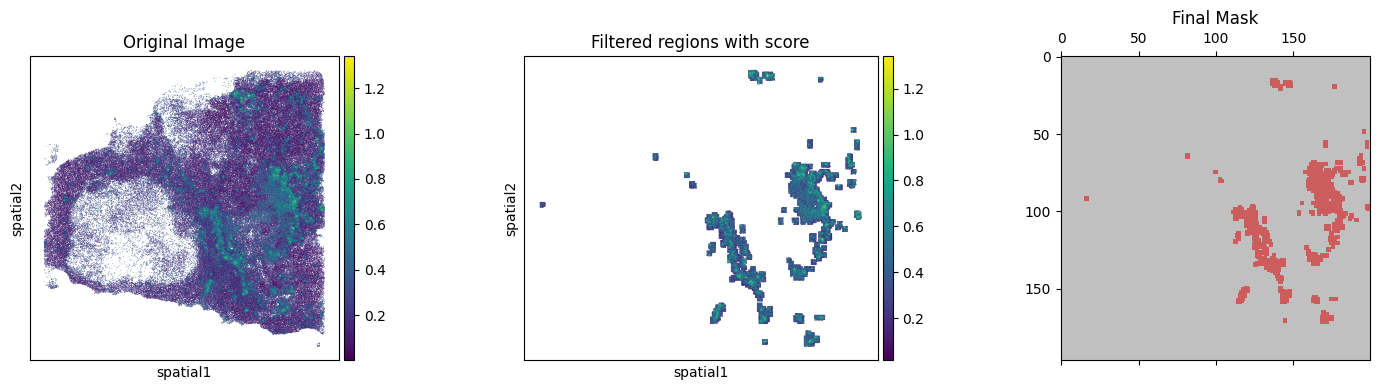

✅ Sample: P1121_LM done!



🔬 Start process sample:	P0516_LM
🔎 Step 1 - Process data:		0.09 s
📊 Spatial cell number to evaluate:		25058
🏋️ Step 2 - KDE scoring:		67.96 s
📊 Using 90 th percentile threshold:		0.000
🔬 Step 3 - Obtain correct coords:		0.10 s
🎨 Plot results 


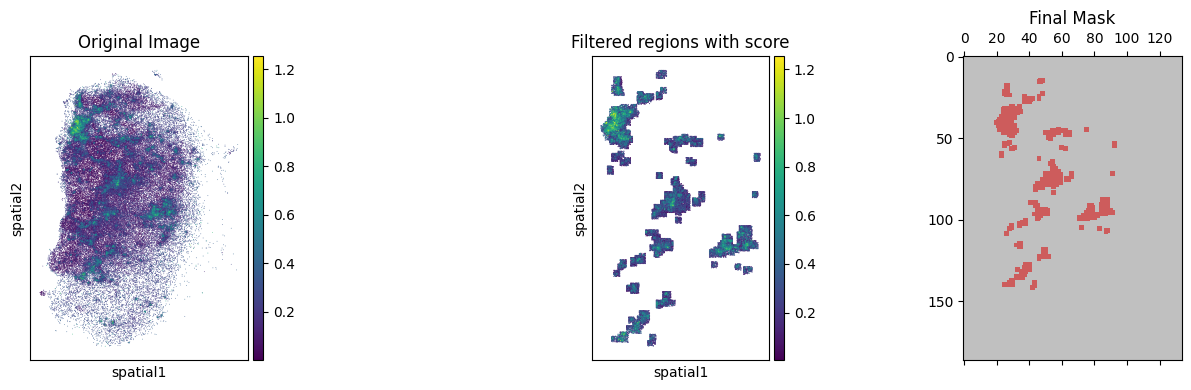

✅ Sample: P0516_LM done!





In [10]:
adata = BAITS.st.tl.batch_process( 
    
    adata=adata, sample_name=sample_name, score_name=score_name,   
    processing_func = BAITS.st.tl.kde_filter, 
    verbose=True,
    func_kwargs={ 'score_name':score_name, 'high_binSize': 100, 'default_thread_num': 36, 'clean_mask_size': (3,3)}
)


In [11]:
adata

AnnData object with n_obs × n_vars = 968003 × 25091
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'celltype', 'sample', 'Bcell_enrichment', 'filtered_coords'
    obsm: 'spatial'

**Using DBscan algorithm to cluster BLA region**

🔬 Start process sample:	P1121_LM


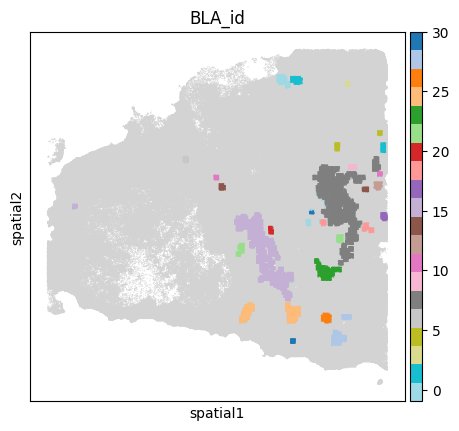

✅ Sample: P1121_LM done!



🔬 Start process sample:	P0516_LM


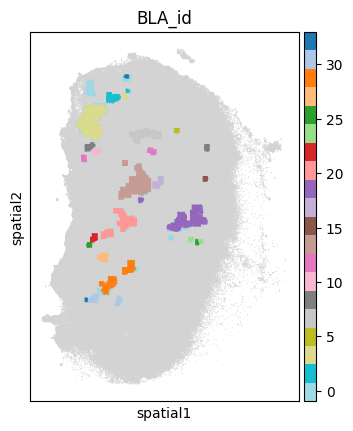

✅ Sample: P0516_LM done!





In [12]:
adata = BAITS.st.tl.batch_process( 
    
    adata=adata, sample_name=sample_name, score_name=score_name,   
    processing_func=BAITS.st.tl.dbscan_cluster, 
    verbose=True,
    func_kwargs={ 'eps': 100, 'min_samples': 50 } 
)


### Step2-2: Processing samples one by one **(Optional)**

To enable sample-specific fine-tuning, users can perform BAITS analysis on individual samples. 

**The analytical procedure is identical to the batch process described in Step 2-1; users may select their preferred configuration method.**

Sample:	 P0516_LM
🔎 Step 1 - Process data:		0.09 s
📊 Spatial cell number to evaluate:		25058
🏋️ Step 2 - KDE scoring:		66.45 s
📊 Using 90 th percentile threshold:		0.000
🔬 Step 3 - Obtain correct coords:		0.17 s
🎨 Plot results 


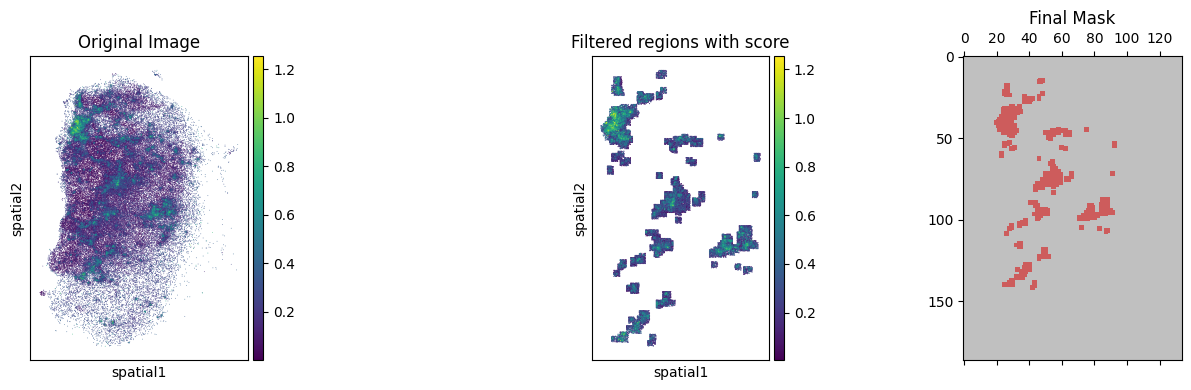

In [13]:
# By using function **BAITS.st.tl.kde_filter**, we could filter cells with low B-cell-score

filtered_adata = []

for sample in ['P0516_LM']:
    print('Sample:\t', sample)
    tmp_ad = adata[adata.obs[sample_name]==sample].copy()
    tmp_res = BAITS.st.tl.kde_filter(tmp_ad, score_name=score_name, plot=True, threshold_method='percentile', custom_threshold=90) 
    
    filtered_adata.append(tmp_res)


In [14]:
adata = ad.concat(filtered_adata)
adata


AnnData object with n_obs × n_vars = 347386 × 25091
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'celltype', 'sample', 'Bcell_enrichment', 'filtered_coords', 'BLA_id'
    obsm: 'spatial'

Sample:	 P0516_LM


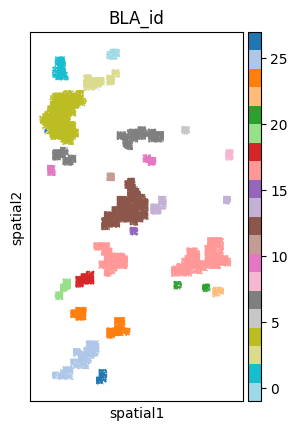

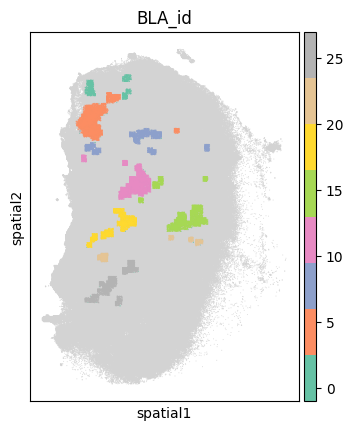

In [15]:
# **st.tl.dbscan_filter** employs the DBSCAN algorithm to identify spatially contiguous cellular domains into BLA.

res_adata = []

for sample in ['P0516_LM']:
    print('Sample:\t', sample)
    sample_ad = adata[adata.obs[sample_name]==sample].copy()
    
    # select region with high B cell score
    tmp_ad = sample_ad[sample_ad.obs['filtered_coords']].copy()
    tmp_res = BAITS.st.tl.dbscan_cluster(tmp_ad)
    
    sample_ad.obs['BLA_id'] = np.nan
    sample_ad.obs.loc[tmp_res.obs.index, 'BLA_id'] = tmp_res.obs['BLA_id']

    sc.pl.spatial(sample_ad, color='BLA_id', spot_size=50, cmap='Set2',
                      legend_fontsize='medium', legend_fontweight='normal',  title='BLA_id', legend_loc='on data')
    
    res_adata.append(sample_ad)
